In [1]:
import torch
import warnings
import torchvision
import torch.nn as nn
import pretrainedmodels
import segmentation_models_pytorch as smp
warnings.filterwarnings("once")

In [3]:
num_classes = 4
resolution = (640, 480)
scale = 1
resolution = int(resolution[0] * scale), int(resolution[1] * scale)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
import pathlib as pl

datasets = [
        {'name': 'Carraca', 'path': pl.Path('Fotos/29.01 - CARRACA 1_ RESERVIBLE SIN MANGO'), 'green_range': (0.984, 0.987)},
        {'name': 'Alicate', 'path': pl.Path('Fotos/20.01 - ALICATES CORTE PLANO'), 'green_range': (0.97, 0.985)},
        {'name': 'Maza', 'path': pl.Path('Fotos/30.01 - MAZA ACERO 2 KG'), 'green_range': (0.97, 0.98)},
        {'name': 'Mordaza', 'path': pl.Path('Fotos/20.01 - MORDAZA UNIVERSAL'), 'green_range': (0.97, 0.985)}
        ]

class_name_to_idx = {'Carraca': 1,
                     'Alicate': 2,
                     'Maza': 3,
                     'Mordaza': 4}
class_idx_to_name = {1: 'Carraca',
                     2: 'Alicate',
                     3: 'Maza',
                     4: 'Mordaza'}

In [6]:
# Get image list:
import glob
import cv2

image_list = []
data = []
labels = []
for dataset in datasets:
    imgs = dataset['path'].glob('*.JPG')
            
    for img in imgs:  
        item = {'img_path': img}
        img_path = item['img_path'] 
        image = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        image = cv2.resize(image, resolution)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        label = class_name_to_idx[dataset['name']] 
        
        labels.append(label)
        data.append(image)
        item.update(dataset)
        image_list.append(item)

In [7]:
import numpy as np

def open_resize_mask(img_path, resolution, green_range):
    
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    img = cv2.resize(img, resolution)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    grenness = img[..., 1].astype(np.float32) / 255
    
    mean_grenn = np.mean(img_hsv[:50, :, 0]) * 0.5 + np.mean(img_hsv[-50:, :, 0]) * 0.5
    
    grenness = 1 - np.abs(img_hsv[..., 0].astype(np.float32) - mean_grenn) / (255 - mean_grenn)
    staturation = 1 - np.abs(img_hsv[..., 2].astype(np.float32) - 130) / 130
    comb = grenness * 0.75 + staturation * 0.25
    
    ferramenta = (grenness <= 0.95) & (staturation < 0.9)
    ferramenta = comb < 0.9
    ferramenta = grenness <= np.random.uniform(green_range[0], green_range[1])
    
    binary = measure.label(ferramenta, background = 0)
    coords = None
    for region in measure.regionprops(binary, coordinates='rc'):
        if region.area < 100:
            coords = region.coords
            ferramenta[coords[:, 0], coords[:, 1]] = 0
    
    
    background = np.logical_not(ferramenta)
    
    return img, ferramenta.astype(np.float32), background.astype(np.float32)

In [8]:
def get_bounding_box_from_seg(binary, width, height):
    
    region = np.where(binary)
    percentile = 0.0
    
    right = np.percentile(region[1], 100 - percentile)
    left = np.percentile(region[1], percentile)
    top = np.percentile(region[0], percentile)
    bottom = np.percentile(region[0], 100 - percentile)
    
    top = np.clip(top, 0, height - 1)
    bottom = np.clip(bottom, 0, height - 1)
    left = np.clip(left, 0, width - 1)
    right = np.clip(right, 0, width - 1)
    
    
    box_width, box_height = right - left, bottom - top
    
    return left, right, top, bottom, box_width, box_height

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_model_pretrained(num_classes):
    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True, 
                                                                 min_size = 480, max_size = 640, 
                                                                 #rpn_pre_nms_top_n_train = 100, 
                                                                 rpn_pre_nms_top_n_test = 30,
                                                                 rpn_post_nms_top_n_test = 20)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
model = get_model_pretrained(num_classes)
model.eval()
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(480,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample):

In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
import albumentations as transforms

class DatasetLoader(Dataset):

    def __init__(self, image_list, resolution, class_name_to_idx, make_transforms = False):
        """
        Este loader carrega as imagens usadas no trabalho de classificação
        
        Args:
            datasets (str): Dicionário contendo: name, path e green_range.
            resolution (tuple): (width, height) of the image.
            class_name_to_idx: Dicionário com as categorias encontradas no dataset
            augmentation (bool): Do dataset augmentation (crete artificial variance) 
        """

        # Parameters   
        self.image_list = image_list
        self.resolution = resolution
        self.class_name_to_idx = class_name_to_idx
        self.transforms = transforms.Compose([
                            transforms.OneOf([transforms.IAAAdditiveGaussianNoise(p = 1), 
                                              transforms.GaussNoise(p = 1)], p = 0.25),
                            transforms.OneOf([transforms.ElasticTransform(p = 1, alpha = 2000, sigma = 50, alpha_affine = 1, 
                                                              border_mode = cv2.BORDER_CONSTANT,mask_value = 0),
                                            transforms.OpticalDistortion(p = 1, border_mode = cv2.BORDER_CONSTANT, mask_value = 0)], p = 0.33),
                            transforms.OneOf([transforms.RandomBrightnessContrast(brightness_limit = 0.1, contrast_limit = 0.1, p = 1),    
                                             transforms.RandomGamma(p = 1)], p=0.5),
                            transforms.OneOf([transforms.MotionBlur(p = 1), 
                                            transforms.MedianBlur(blur_limit = 3, p = 1),
                                            transforms.Blur(p = 1)], p = 0.1),
                                            transforms.HueSaturationValue(p = 0.25),
                                            transforms.ShiftScaleRotate(p = 0.75, scale_limit = 0.3, shift_limit = 0.3, 
                                                              border_mode = cv2.BORDER_CONSTANT, rotate_limit = 360, mask_value = 0),
                                            transforms.ToGray(p = 0.2)], p = 1)
        self.make_transforms = make_transforms
        self.total_samples = len(self.image_list)    
        self.random_image_list = list(pl.Path('Random-Images').glob('*.jpeg'))
        self.number_random_images = len(self.random_image_list) 
        
        print('Total samples: %d' % self.total_samples)      
        
        # Mean and std are needed because we start from a pre trained net
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
                
    def __len__(self):
        return self.total_samples
    
    def __getitem__(self, i):
        
        # Define imagens e classes
        item = self.image_list[i]
        img_path = item['img_path']
        img_label = self.class_name_to_idx[item['name']]
            
        # Segmenta a imagem 
        img, tool_mask, background = open_resize_mask(img_path, self.resolution, item['green_range'])
        
        if self.make_transforms:
                            
            # Aplica augmentation
            ret = self.transforms(image = img, mask = tool_mask)
            img, tool_mask = ret['image'], ret['mask'].astype(np.bool)
            img_box = get_bounding_box_from_seg(tool_mask, *self.resolution)
            
            
            # Pega ferramentas de modo aleatório para adicionar na imagem
            num_add_tools = np.random.randint(0, 4)
            add_tool_info = []
            for num_add_tool in range(num_add_tools):                
                item_index = np.random.randint(0, self.total_samples) 
                img_2, ferramenta_2, background_2 = open_resize_mask(self.image_list[item_index]['img_path'], 
                                                                     self.resolution, 
                                                                     self.image_list[item_index]['green_range'])
                sc = self.class_name_to_idx[self.image_list[item_index]['name']]
                add_tool_info.append({'img': img_2, 'mask': ferramenta_2, 'class': sc})                
            
            # Faz augmentation e calcula o bouding box
            for add_tool in add_tool_info:
                ret = self.transforms(image = add_tool['img'], mask = add_tool['mask'])
                add_tool['img'], add_tool['mask'] = ret['image'], ret['mask'].astype(np.bool)
                add_tool['bb'] = get_bounding_box_from_seg(add_tool['mask'], *self.resolution)
            
            ferramentas = tool_mask
            for add_tool in add_tool_info:
                img[add_tool['mask']] = add_tool['img'][add_tool['mask']]
                ferramentas |= add_tool['mask']
                                             
            # Adiciona novo background
            background_total = np.logical_not(ferramentas)    
            if np.random.rand() < 0.5:
                index_img = np.random.randint(0, self.number_random_images)
                background_image = cv2.imread(str(self.random_image_list[index_img]))
                background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
                background_image_np = cv2.resize(background_image, self.resolution)
                img[background_total] = background_image_np[background_total]
            else:
                background_image = cv2.imread('White/white.png')
                background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)
                background_image_np = cv2.resize(background_image, self.resolution)
                img[background_total] = background_image_np[background_total]
            
            #Merge images, boxes and labels
            boxes = []
            labels = []
            labels.append(img_label)
            boxes.append([img_box[0], img_box[2], img_box[1], img_box[3]])
            for add_tool in add_tool_info:
                boxes.append([add_tool['bb'][0], add_tool['bb'][2], add_tool['bb'][1], add_tool['bb'][3]])
                labels.append(add_tool['class'])
        else:                            
            # Segmenta a imagem 
            img, tool_mask, background = open_resize_mask(img_path, self.resolution, item['green_range'])
            img_box = get_bounding_box_from_seg(tool_mask, *self.resolution)
            
            # save
            boxes = []
            labels = img_label
            boxes.append([img_box[0], img_box[2], img_box[1], img_box[3]])
            
        iscrowd = torch.tensor([0]*len(boxes), dtype=torch.int64)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)        
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([i])        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  
        
        target = {
          "boxes": boxes,
          "labels": labels,
          "image_id": image_id,
          "area": area,
          "iscrowd": iscrowd,
        }
        
        # Normalizando a imagem
        img_pt = img.astype(np.float32) / 255.0
        img_pt = img_pt.transpose(2,0,1)        
        img_pt = torch.from_numpy(img_pt)
        
        return img_pt, target, img
            
dataset_test = DatasetLoader(image_list = image_list, 
                            resolution = resolution, 
                            class_name_to_idx = class_name_to_idx, 
                            make_transforms = True)  

Total samples: 112


<ipython-input-7-7fcd435a8b96>:25: FutureWarning: The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.
  for region in measure.regionprops(binary, coordinates='rc'):


Model time: 0.000017
Carraca
Carraca
Maza


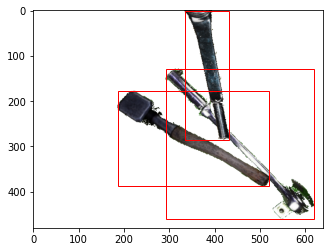

Model time: 0.000022
Carraca
Alicate
Mordaza
Carraca


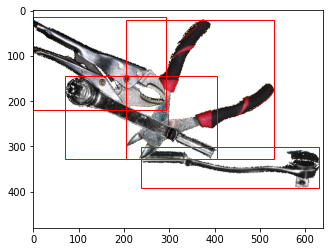

Model time: 0.000017
Carraca


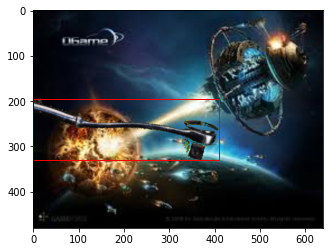

Model time: 0.000018
Carraca
Mordaza
Maza
Carraca


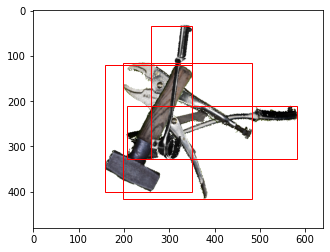

Model time: 0.000019
Carraca
Carraca
Alicate


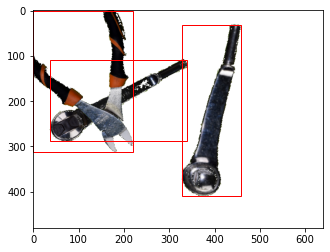

Model time: 0.000019
Carraca
Alicate


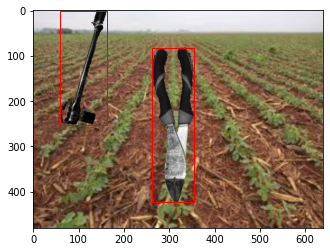

Model time: 0.000040
Carraca
Alicate
Mordaza


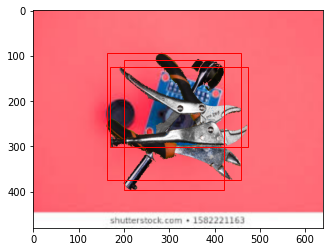

Model time: 0.000019
Carraca
Carraca


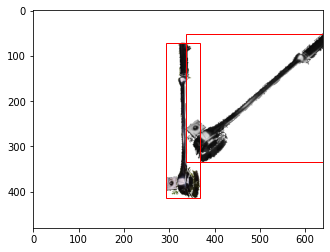

Model time: 0.000017
Carraca
Mordaza
Carraca
Mordaza


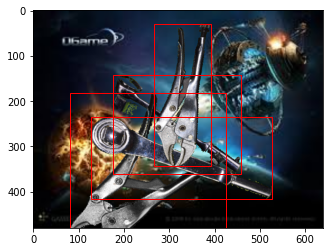

Model time: 0.000022
Carraca
Maza


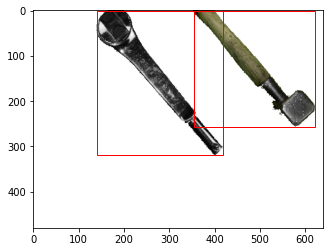

Model time: 0.000019
Carraca


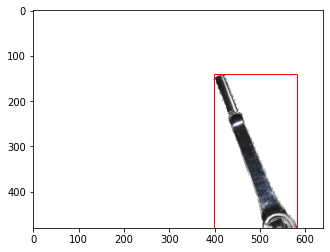

Model time: 0.000021
Carraca


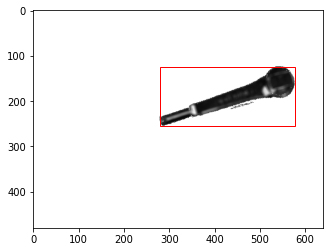

Model time: 0.000018
Carraca
Maza


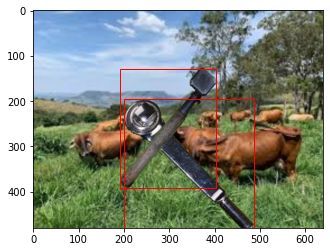

Model time: 0.000022
Carraca


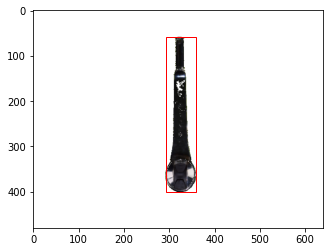

Model time: 0.000018
Carraca
Alicate
Carraca
Carraca


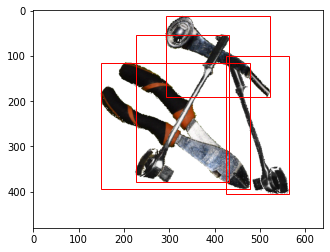

KeyboardInterrupt: 

In [15]:
import time
import matplotlib.patches as patches
from skimage import measure

for img_pt, target, img_np in dataset_test:
    
    st = time.time()
    
    # Definindo as boxes 
    image_np = img_np
    target_box = target['boxes'].cpu().numpy().astype(np.int)
    
    # Fazer o modelo calcular as boxes
    #img_pt = img_pt.to(device)
    #outputs = model([img_pt])
    #outputs = [{k: v.cpu().detach().numpy() for k, v in t.items()} for t in outputs]
    #box = outputs[0]['boxes'][0].astype(np.int)
    
    # Printando o tempo usado para o programa calcular as boxes
    print('Model time: %f' % (time.time()-st))
    
    # Plotando o resultado
    target_label = target['labels']    
    target_label_np = target_label.numpy()
    
    fig,ax = plt.subplots(1)
    ax.imshow(image_np) 
    for index_tool in range(len(target_box)):   
        print(class_idx_to_name[target_label_np[index_tool]])
        
        rect = patches.Rectangle((target_box[index_tool][0], target_box[index_tool][1]), 
                                 target_box[index_tool][2] - target_box[index_tool][0], 
                                 target_box[index_tool][3] - target_box[index_tool][1],
                                 linewidth = 1, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
    plt.show()

In [5]:
torch.ones((4,), dtype=torch.int64)

tensor([1, 1, 1, 1])